In [2]:
from collections import Counter
import cv2
import glob
# import skimage
import numpy as np
import pandas as pd
import seaborn as sn
from tqdm import tqdm
from os import listdir
import matplotlib.pyplot as plt
from skimage.transform import resize
from collections import Counter
import warnings
warnings.filterwarnings("ignore")
import itertools
sn.set()

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from time import time

from sklearn import metrics
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score,f1_score,recall_score,cohen_kappa_score,precision_score, roc_curve
from sklearn.utils import compute_class_weight
from sklearn.preprocessing import MinMaxScaler,LabelBinarizer, LabelEncoder
# from sklearn.neighbors import KNeighborsClassifier # KNeighborsClassifier
# from sklearn.svm import SVC # SVM
# from sklearn.ensemble import RandomForestClassifier # RandomForestClassifier
# from sklearn.ensemble import AdaBoostClassifier # AdaBoostClassifier
# from xgboost import XGBClassifier # XGBClassifier
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, Adamax, SGD

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import AUC
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, Sequential
# from tensorflow.keras.applications.vgg16 import VGG16 # VGG16
# from tensorflow.keras.applications.vgg19 import VGG19 # VGG19
# from tensorflow.keras.applications.resnet50 import ResNet50 # ResNet50
# from tensorflow.keras.applications import ResNet101 # ResNet 101
from tensorflow.keras.applications.xception import Xception # Xception
# from tensorflow.keras.applications.mobilenet import MobileNet # MobileNet
# from tensorflow.keras.applications.densenet import DenseNet169 # DenseNet169
# from tensorflow.keras.applications.densenet import DenseNet121 # DenseNet121
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2 # MobileNetV2
# from tensorflow.keras.applications.inception_resnet_v2 import inception_resnet_v2

# from tensorflow.keras.applications.inception_v3 import InceptionV3 # InceptionV3
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Flatten, Activation, GlobalAveragePooling2D,Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
from PIL import Image

In [3]:
df = pd.read_csv('/kaggle/input/extracting-attributes-from-fashion-images-jan-2024/train.csv')


In [4]:
df

,file_name,label
0,Image_train_00001.jpg,0
1,Image_train_00002.jpg,1
2,Image_train_00003.jpg,0
3,Image_train_00004.jpg,0
4,Image_train_00005.jpg,0
...,...,...
18386,Image_train_18387.jpg,1
18387,Image_train_18388.jpg,2
18388,Image_train_18389.jpg,1
18389,Image_train_18390.jpg,1


In [5]:
train_path = '/kaggle/input/extracting-attributes-from-fashion-images-jan-2024/train'
def listify(x):
    li = list()
    li.append(x)
    return li

df['file_name'] = df['file_name'].apply(lambda x: os.path.join(train_path, x))
df['label'] = df['label'].apply(lambda x: listify(x))

In [6]:
train_df, test_df= train_test_split(df, stratify=df['label'], shuffle=True, random_state=42)

In [7]:
train_datagen = image.ImageDataGenerator(rescale= 1./255,  horizontal_flip = True)
val_test_datagen = image.ImageDataGenerator(rescale=1./255)

batch_size = 64
target_size = (256, 256)

# Define the train and test generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='file_name',
    y_col='label',
    class_mode='categorical',
    shuffle=True,
    batch_size=batch_size,
    target_size=target_size,
    subset='training'
)

test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='file_name',
    y_col='label',
    shuffle=False,
    class_mode='categorical',
    batch_size=batch_size,
    target_size=target_size
)

Found 13793 validated image filenames belonging to 7 classes.
Found 4598 validated image filenames belonging to 7 classes.


In [8]:
img_size = (256, 256)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_generator.class_indices.keys())) # to define number of classes in dense layer

base_model = Xception(include_top= False, weights= "imagenet", input_shape= img_shape)

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation = 'relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(7, activation = 'sigmoid')
])

model.compile(optimizer="sgd", loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()


83683744/83683744 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 batch_normalization_4 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                         

In [9]:
early_stopping_callbacks =EarlyStopping(monitor='val_loss',patience = 4, restore_best_weights = True, verbose = 1)

history = model.fit(train_generator,
    validation_data=test_generator,
    epochs=10,
    steps_per_epoch = 100,
    callbacks = [early_stopping_callbacks])

Epoch 1/10
100/100 [==============================] - 128s 1s/step - loss: 1.6364 - accuracy: 0.4008 - val_loss: 1.7073 - val_accuracy: 0.4513
Epoch 2/10
100/100 [==============================] - 90s 897ms/step - loss: 1.1334 - accuracy: 0.5844 - val_loss: 1.5780 - val_accuracy: 0.5250
Epoch 3/10
100/100 [==============================] - 89s 893ms/step - loss: 0.9353 - accuracy: 0.6494 - val_loss: 1.3827 - val_accuracy: 0.5581
Epoch 4/10
100/100 [==============================] - 89s 890ms/step - loss: 0.8676 - accuracy: 0.6744 - val_loss: 1.1855 - val_accuracy: 0.6018
Epoch 5/10
100/100 [==============================] - 93s 924ms/step - loss: 0.7780 - accuracy: 0.7014 - val_loss: 0.9782 - val_accuracy: 0.6540
Epoch 6/10
100/100 [==============================] - 89s 889ms/step - loss: 0.7294 - accuracy: 0.7183 - val_loss: 0.8909 - val_accuracy: 0.6516
Epoch 7/10
100/100 [==============================] - 89s 893ms/step - loss: 0.6862 - accuracy: 0.7381 - val_loss: 0.8684 - val_accu

In [10]:
def plot_training(hist):
    """
    visualize the training and validation performance of a machine learning model over epochs. 
    It plots two subplots
    1.training and validation loss 
    2. training and validation accuracy, 
    highlighting the epochs with the lowest validation loss and the highest validation accuracy
    """
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout
    plt.show()
    

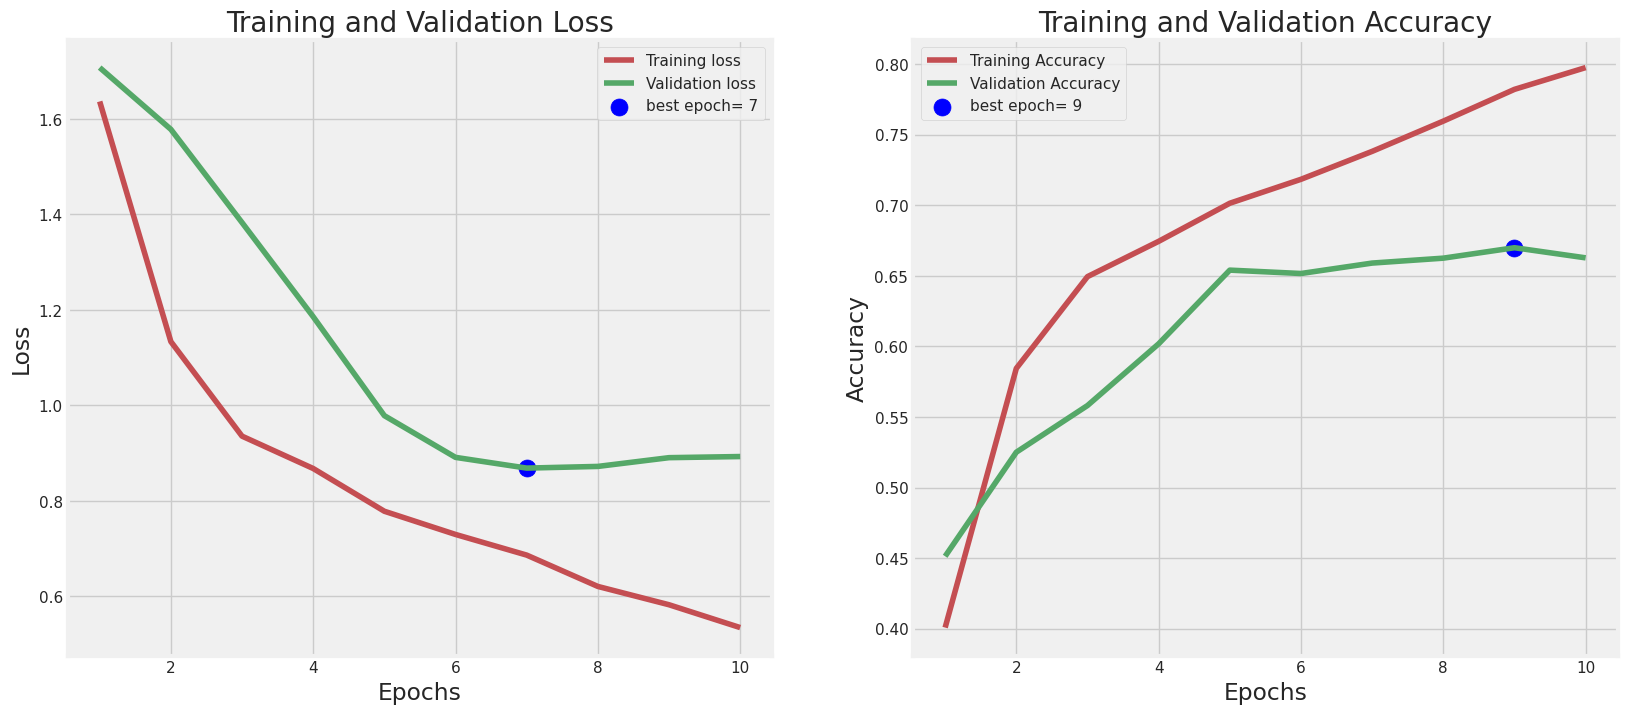

In [11]:
plot_training(history)

In [12]:
predicted_labels = model.predict(test_generator)
true_labels = test_generator.classes
predicted_labels.shape

72/72 [==============================] - 25s 330ms/step


(4598, 7)

In [13]:
def get_labels(preds):
    label = []
    for pred in preds:
        label.append(pred.argmax())
        
    return label

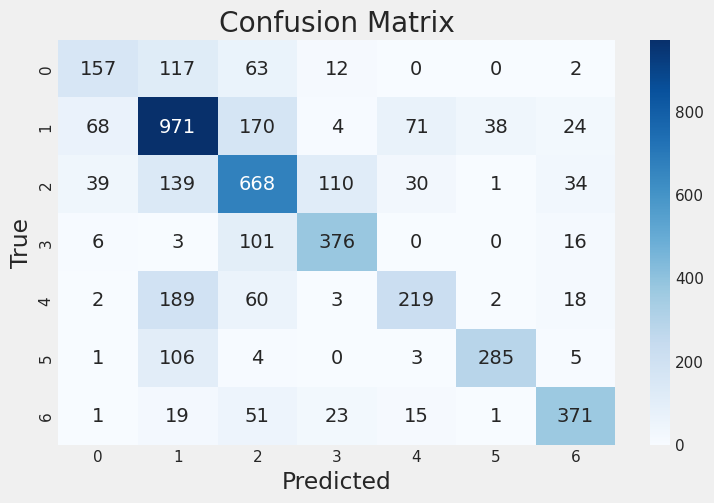

In [14]:
plt.figure(figsize = (8,5))
sn.heatmap(confusion_matrix(true_labels, get_labels(predicted_labels)), annot = True,fmt="d",cmap = "Blues", xticklabels=['0', '1', '2', '3', '4', '5', '6'], yticklabels=['0', '1', '2', '3', '4', '5', '6'])

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [15]:
y_pred = get_labels(predicted_labels)


In [16]:
print(classification_report(test_generator.classes,y_pred,  target_names= ['0', '1', '2', '3', '4', '5', '6'] ))


              precision    recall  f1-score   support

           0       0.57      0.45      0.50       351
           1       0.63      0.72      0.67      1346
           2       0.60      0.65      0.62      1021
           3       0.71      0.75      0.73       502
           4       0.65      0.44      0.53       493
           5       0.87      0.71      0.78       404
           6       0.79      0.77      0.78       481

    accuracy                           0.66      4598
   macro avg       0.69      0.64      0.66      4598
weighted avg       0.67      0.66      0.66      4598



In [17]:
from pathlib import Path

In [18]:
test_path = Path('/kaggle/input/extracting-attributes-from-fashion-images-jan-2024/test')

In [19]:
def get_img_from_path(path):
    img = tf.io.read_file(str(path))
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [256, 256])
    img = img / 255.0  # normalize to [0,1] range
    img = tf.expand_dims(img, 0)  # add batch dimension
    return img
    

In [ ]:

test_img_paths = list(test_path.glob('*.jpg'))
preds_list = []

for path in test_img_paths:
    img = get_img_from_path(path)
    pred = model.predict(img)
    label = pred.argmax()
    preds_list.append(label)

In [23]:
len(preds_list), len(test_img_paths)

(5751, 5751)

In [33]:
str(test_img_paths[:5][0])[-20:]
file_names = []
for path in test_img_paths:
    file_names.append(str(path)[-20:])
    
file_names[:5]

['Image_test_03058.jpg',
 'Image_test_02479.jpg',
 'Image_test_05379.jpg',
 'Image_test_01202.jpg',
 'Image_test_03064.jpg']

In [34]:
submission_df = pd.DataFrame({'file_name':file_names, 'label': preds_list})

In [36]:
submission_df.to_csv('submission.csv', index=False)